# A2: Bias in data
## Dane Jordan

Import necessary libraries that will be used

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests

%matplotlib inline


### Getting the article and population data

In [2]:
# read in the data from the page_data.csv file
page_data = pd.read_csv('../data_raw/page_data.csv', dtype={'rev_id': str})

# read in the data from the population csv file
population_data = pd.read_csv('../data_raw/Population Mid-2015.csv', header=1, thousands=',')


### Getting article quality predictions

In [3]:
# create a list of lists where each nested list contains 100 revids delimited by '|'
revid_list = []
for i in range(len(page_data)):
    if i % 100 == 0:
        revid_list.insert(i // 100, [str(page_data['rev_id'][i])])
    else:
        revid_list[i // 100].append(str(page_data['rev_id'][i]))


In [4]:
# initialize a list to store the prediction values
predictions = []
missing_revid = []

# loop through the the revid lists (batches of 100) and call the api
for i in range(len(revid_list)):
    endpoint = 'https://ores.wikimedia.org/v3/scores/{context}?models={models}&revids={revids}'

    params = {'context' : 'enwiki',
              'models' : 'wp10',
              'revids' : '|'.join(revid_list[i])
              }

    api_call = requests.get(endpoint.format(**params))

    response = api_call.json()
    
    # loop through the response for the batch of 100 revids and append the prediction to the prediction list
    for j in response['enwiki']['scores']:
        
        # check for missing revids (potentially articles that have been deleted)
        try:
            predictions.append([j, response['enwiki']['scores'][j]['wp10']['score']['prediction']])
            
        # if artile is missing, attribute an 'NA' prediction and store the missing revid
        except KeyError:
            predictions.append([j, 'NA'])
            missing_revid.append(j)

# print the count and list of missing revids
print('There were a total of ' + str(len(missing_revid)) + ' missing revids. They are as follows: ' + str(sorted(missing_revid)))


There were a total of 2 missing revids. They are as follows: ['807367030', '807367166']


### Combining the datasets

In [14]:
# convert predictions to a dataframe and add column names
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = ['revid', 'prediction']

# drop duplicates (this was included for the duplicate revids--no longer needed with the updated page_data.csv)
predictions_df = predictions_df.drop_duplicates()

# merge the predictions with the page_data
page_data_new = page_data.merge(predictions_df, how='left', left_on='rev_id', right_on='revid')
page_data_new = page_data_new.drop('revid', axis=1)

# merge the two data sets (page_data_new and population_data) and add specified column names
combined_data = page_data_new.merge(population_data[['Location', 'Data']], left_on='country', right_on='Location')
combined_data = combined_data.drop('Location', axis=1)
combined_data.columns = ['article_name', 'country', 'revision_id', 'article_quality', 'population']

# output file to csv
combined_data.to_csv('../data_clean/combined_data.csv', index=False)


### Analysis

In [27]:
# identify all of the countries (removing duplicates)
country = combined_data['country'].unique()

# count the total number of articles (NOTE: this includes articles with missing revids from the api call) per country
num_articles = combined_data.groupby('country')['article_name'].count()

#  count the number of 'high-quality' articles per country
hq_articles = combined_data[(combined_data['article_quality'] == 'FA') |
                            (combined_data['article_quality'] == 'GA')
                           ].groupby('country')['article_quality'].count().reindex(list(country), fill_value=0)

# get the population per country
population = combined_data.groupby('country')['population'].max()

# calculate the two 'analysis' variables:
# 1. proportion (as a percentage) of articles-per-population for each country
# 2. proportion (as a percentage) of high-quality articles for each country
articles_per_population = 100*(num_articles / population)
percentage_hq_articles = 100*(hq_articles/num_articles)

# combine thee two 'analysis' variables into a dataframe
analysis = pd.DataFrame({'country': country.tolist(),
                         'articles_per_population': articles_per_population.tolist(),
                         'percentage_hq_articles': percentage_hq_articles.tolist()
                        })

# reorder the columns in the dataframe
analysis = analysis[['country', 'articles_per_population', 'percentage_hq_articles']]


### Visualization

In [19]:
# sort the analysis dataframe based on the key attributes and only return the first 10
viz1 = analysis.sort_values('articles_per_population', ascending=False)[['country', 'articles_per_population']][0:10]
viz2 = analysis.sort_values('articles_per_population')[['country', 'articles_per_population']][0:10]
viz3 = analysis.sort_values('percentage_hq_articles', ascending=False)[['country', 'percentage_hq_articles']][0:10]

# this visualization will be handled as a list, since there are more than 10 countries with no high-quality articles
viz4 = analysis[analysis['percentage_hq_articles'] == 0][['country', 'percentage_hq_articles']]


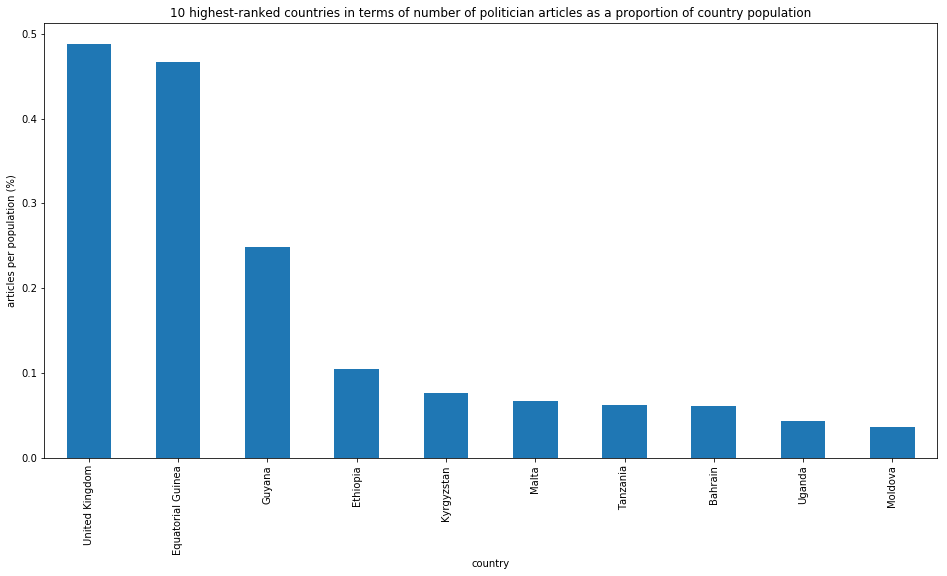

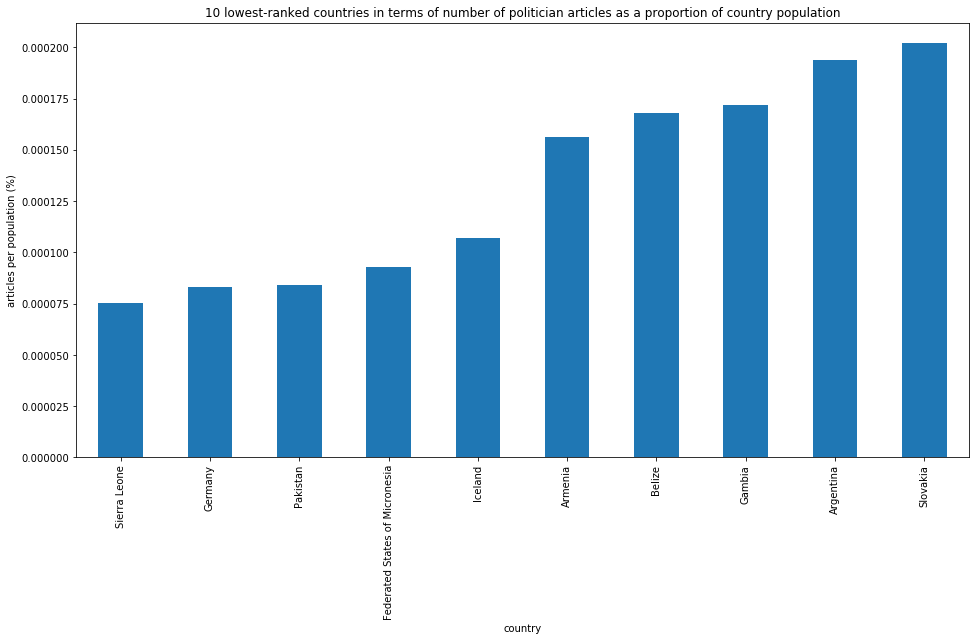

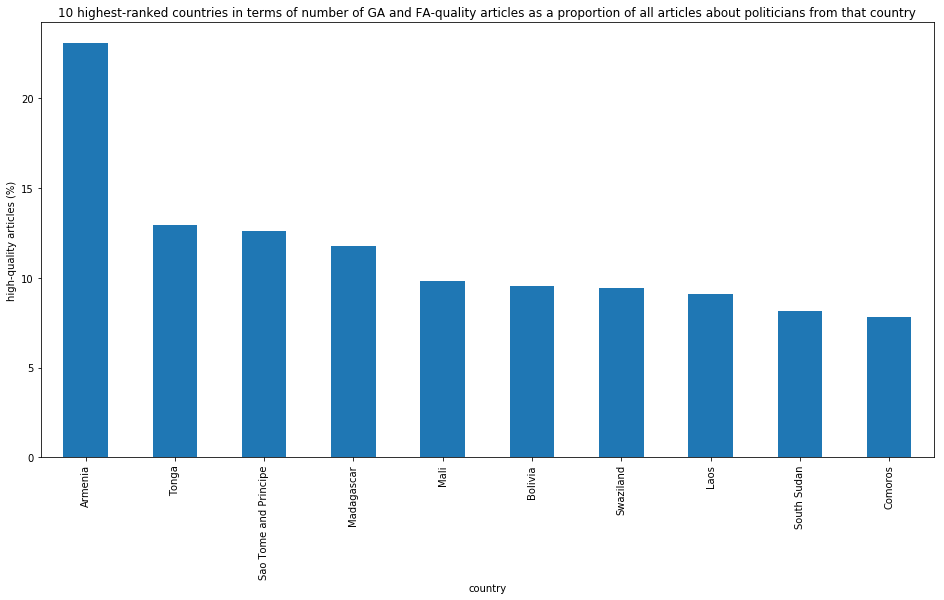

In [31]:
# create bar plots for the first three visualizations
ax = viz1.plot(x=viz1['country'], kind='bar', figsize=(16, 8), title='10 highest-ranked countries in terms of number of politician articles as a proportion of country population', legend=False)
ax.set_xlabel('country')
ax.set_ylabel('articles per population (%)')
ax = viz2.plot(x=viz2['country'], kind='bar', figsize=(16, 8), title='10 lowest-ranked countries in terms of number of politician articles as a proportion of country population', legend=False)
ax.set_xlabel('country')
ax.set_ylabel('articles per population (%)')
ax = viz3.plot(x=viz3['country'], kind='bar', figsize=(16, 8), title='10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country', legend=False)
ax.set_xlabel('country')
ax.set_ylabel('high-quality articles (%)')


In [41]:
# create a table for the fourth visualization
print('10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country')
viz4.reset_index(drop=True)


10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country


,country,percentage_hq_articles
0,Uganda,0.0
1,Nigeria,0.0
2,Somalia,0.0
3,Cambodia,0.0
4,Slovenia,0.0
5,Iraq,0.0
6,Nepal,0.0
7,Burkina Faso,0.0
8,Indonesia,0.0
9,Ghana,0.0


### Writeup